In [1]:
#written by Marina Ricci

#purposes: handling cosmoDC2 DESC catalog and investigating the properties of galaxy clusters 
# (defined as halos with M_halo>1e14 Msol)


#TODOS
# include dn/dz 
# include M*(z)
# include NFW parametrisation

### Purpose of this notebook: 
Objects in mock catalogs have to be representative of the their true population. In this context, this notebook aims at testing some basic statistical properties of galaxies belonging to clusters (arbitrarly defined here as halos with friend of friend mass > 10^14 Msol). The properties tested are : the mass/redshift distribution, the "richness"/mass relation, the density profile, the luminosity function and the color magnitude diagrams. These are the main intrinsic properties that drive cluster detection in the optical/NIR. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import GCRCatalogs
from GCR import GCRQuery
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.stats import normaltest
import matplotlib.colors as clr
%matplotlib inline

## - Handling the catalog

In [3]:
# see all available catalogs
print(sorted(GCRCatalogs.get_available_catalogs(False)))

['cosmoDC2_v1.0', 'cosmoDC2_v1.0_9431_9812', 'cosmoDC2_v1.0_small', 'cosmoDC2_v1.1.4_image', 'cosmoDC2_v1.1.4_image_addon_knots', 'cosmoDC2_v1.1.4_small']


In [4]:
# load a calalog
catalog1 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

#print catalog info
print(catalog1.get_catalog_info())

{'subclass_name': 'cosmodc2.CosmoDC2GalaxyCatalog', 'catalog_root_dir': '/sps/lsst/data/desc/catalogs/cosmoDC2/cosmoDC2_v1.1.4_rs_scatter_query_tree_double', 'catalog_filename_template': 'z_{}_{}.step_all.healpix_{}.hdf5', 'cosmology': {'H0': 71.0, 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.8, 'n_s': 0.963}, 'lightcone': True, 'version': '1.1.4', 'healpix_pixels': [9559, 9686, 9687, 9814, 9815, 9816, 9942, 9943, 10070, 10071, 10072, 10198, 10199, 10200, 10326, 10327, 10450], 'check_md5': False, 'check_size': False, 'check_cosmology': False, 'creators': ['Andrew Hearin', 'Danila Korytov', 'Eve Kovacs', 'Esteban Rangel', 'Patricia Larsen', 'Joe Hollowed', 'Andrew Benson', 'Katrin Heitmann'], 'description': 'This is the extra-galactic catalog for the LSST-DESC data challenge DC2.\n', 'included_by_default': True}


In [5]:
#define same cosmological parameters as the catalog
cosmo = FlatLambdaCDM(H0=71, Om0=0.2648, Ob0=0.0448) #not 100% sure it is the same cosmo as in the simu

In [6]:
# print all available quantities in the catalog
print(sorted(catalog1.list_all_quantities()))

['A_v', 'A_v_bulge', 'A_v_disk', 'Mag_true_Y_lsst_z0', 'Mag_true_Y_lsst_z0_no_host_extinction', 'Mag_true_g_lsst_z0', 'Mag_true_g_lsst_z0_no_host_extinction', 'Mag_true_g_sdss_z0', 'Mag_true_g_sdss_z0_no_host_extinction', 'Mag_true_i_lsst_z0', 'Mag_true_i_lsst_z0_no_host_extinction', 'Mag_true_i_sdss_z0', 'Mag_true_i_sdss_z0_no_host_extinction', 'Mag_true_r_lsst_z0', 'Mag_true_r_lsst_z0_no_host_extinction', 'Mag_true_r_sdss_z0', 'Mag_true_r_sdss_z0_no_host_extinction', 'Mag_true_u_lsst_z0', 'Mag_true_u_lsst_z0_no_host_extinction', 'Mag_true_u_sdss_z0', 'Mag_true_u_sdss_z0_no_host_extinction', 'Mag_true_y_lsst_z0', 'Mag_true_y_lsst_z0_no_host_extinction', 'Mag_true_z_lsst_z0', 'Mag_true_z_lsst_z0_no_host_extinction', 'Mag_true_z_sdss_z0', 'Mag_true_z_sdss_z0_no_host_extinction', 'R_v', 'R_v_bulge', 'R_v_disk', 'bulge_to_total_ratio_i', 'convergence', 'dec', 'dec_true', 'ellipticity_1_bulge_true', 'ellipticity_1_disk_true', 'ellipticity_1_true', 'ellipticity_2_bulge_true', 'ellipticity_2

## - Selection of halos with Mass >1e14 (referred to as clusters in the following) in the selected sub-sample

In [7]:
# load quantities of interest (may take a few minutes)
cluster_data = catalog1.get_quantities(['ra', 'dec','redshift','halo_mass', 'halo_id','is_central','mag_r_lsst','mag_i_lsst','mag_Y_lsst','Mag_true_u_lsst_z0','Mag_true_g_lsst_z0','Mag_true_i_lsst_z0'], filters=['halo_mass > 10**(14)'])

## - Number of clusters in the catalog

In [8]:
is_central = (cluster_data['is_central'])
print ("Number of clusters: ", np.sum(is_central))

Number of clusters:  475


# 1 - Ra-dec distribution of the clusters

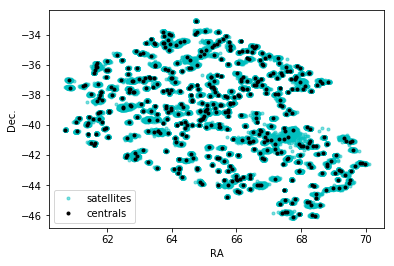

In [9]:
plt.figure()
plt.plot(cluster_data['ra'],cluster_data['dec'],'c.',alpha=0.5,label='satellites')
plt.plot(cluster_data['ra'][is_central],cluster_data['dec'][is_central],'k.',label='centrals')
plt.legend(loc=3)
plt.xlabel('RA')
plt.ylabel('Dec.');

# 2 - Cluster mass-redshift distribution

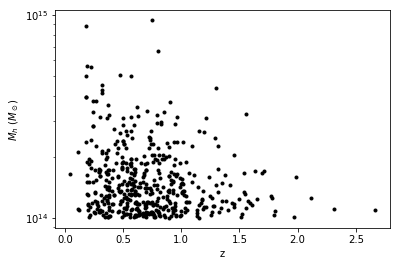

In [10]:
plt.figure()
plt.plot(cluster_data['redshift'][is_central],cluster_data['halo_mass'][is_central],'k.')
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('$M_{h}$ ($M_\odot$)');

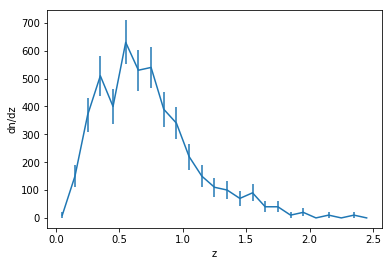

In [11]:
#number of clusters per redshift unit in the 54 degrees of the simulation (+ Poissonian error bars)

dndz_hist = np.histogram(cluster_data['redshift'][is_central],bins=25,range=[0,2.5])
zbin_size = (dndz_hist[1][1]-dndz_hist[1][0])
zbin_center = dndz_hist[1][:-1]+zbin_size/2.

plt.figure()
plt.errorbar(zbin_center,dndz_hist[0]/zbin_size,yerr=np.sqrt(dndz_hist[0])/zbin_size) 
plt.xlabel('z')
plt.ylabel('dn/dz');

(10, 5000.0)

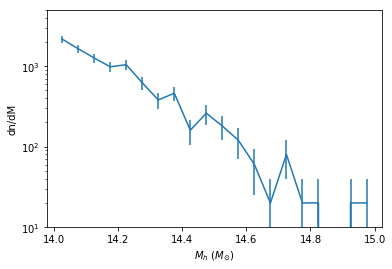

In [12]:
#number of clusters per mass unit in the 54 degrees of the simulation (+ Poissonian error bars), beetween z=0 and z=3

dndM_hist = np.histogram(np.log10(cluster_data['halo_mass'][is_central]),bins=20,range=[14,15])
Mbin_size = (dndM_hist[1][1]-dndM_hist[1][0])
Mbin_center = dndM_hist[1][:-1]+Mbin_size/2.

plt.figure()
plt.errorbar(Mbin_center,dndM_hist[0]/Mbin_size,yerr=np.sqrt(dndM_hist[0])/Mbin_size) 
plt.xlabel('$M_{h}$ ($M_{\odot}$)')
plt.ylabel('dn/dM');
plt.yscale('log')
plt.ylim(10,5e3)

### The shape of the distributions looks OK, but more work is needed to compare to expectations (work in progress)

# 3 - Number of member galaxies as a function of halo mass

In [13]:
#compute the number of galaxies associated to each halo

ngal = np.zeros(np.sum(is_central))
for i in range(np.sum(is_central)):
    ngal[i] = ((GCRQuery('halo_id == {}'.format(cluster_data['halo_id'][is_central][i])).filter(cluster_data))['redshift']).size

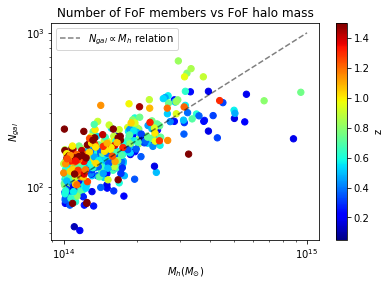

In [14]:
#plot the number of associated galaxy as a function of halo mass, color-coded by redshift

plt.figure()
plt.title('Number of FoF members vs FoF halo mass')
plt.scatter(cluster_data['halo_mass'][is_central],ngal,c=cluster_data['redshift'][is_central],s=40,cmap='jet',vmax=1.5)
clb = plt.colorbar()
clb.set_label('z')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$M_{h} (M_{\odot})$')
plt.ylabel('$N_{gal}$');

#add an arbitrary power law with slope = 1 for vizualisation purpose
x = 10**np.linspace(14,15,10)
Ampl,slope = 1./1e12, 1.0
plt.plot(x,Ampl*x**(slope),'k--',alpha=0.5,label='$N_{gal}\propto M_{h}$ relation')
plt.legend()

In [15]:
#compute the number of galaxies associated to each halo, within a projected radius "rmax"

dist_to_central_Mpc_list = []
rmax=0.75 #Mpc (arbitrary value)

ngal_rmax = np.zeros(np.sum(is_central))

for i in range(np.sum(is_central)):
    halo = cluster_data['halo_id'][is_central][i]
    #definition of the coordinates and redshift of the central galaxy of each halo
    ra_ref = cluster_data['ra'][is_central][i]
    dec_ref = cluster_data['dec'][is_central][i]
    z_ref = cluster_data['redshift'][is_central][i]   
    #compute the distance to the central galaxy for each galaxy belonging to a halo, in degree
    dist_to_central_deg =  (np.sqrt((cluster_data['ra'][(cluster_data['halo_id']==halo)]-ra_ref)**2+(cluster_data['dec'][(cluster_data['halo_id']==halo)]-dec_ref)**2))
    #convert the distance to Mpc
    dist_to_central_Mpc = cosmo.kpc_proper_per_arcmin(z_ref).value*(dist_to_central_deg)*60./1e3
    dist_to_central_Mpc_list.append(dist_to_central_Mpc) #(needed for section 5)
    #count the number of member galaxies within a projected radius "rmax"
    ngal_rmax[i] = np.sum(dist_to_central_Mpc<rmax)
  

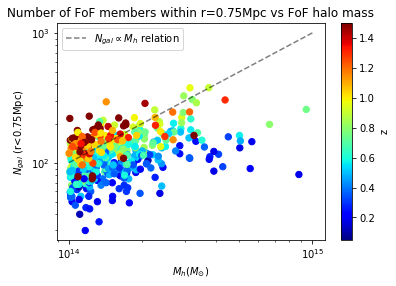

In [16]:
plt.figure()
plt.scatter(cluster_data['halo_mass'][is_central],ngal_rmax,c=cluster_data['redshift'][is_central],s=40,cmap='jet',vmax=1.5)
clb=plt.colorbar()
clb.set_label('z')
plt.yscale('log')
plt.xscale('log')
plt.title('Number of FoF members within r='+str(rmax)+'Mpc vs FoF halo mass')
plt.xlabel('$M_{h} (M_{\odot})$')
plt.ylabel('$N_{gal}$ (r<'+str(rmax)+'Mpc)');


#add an arbitrary power law with slope = 1 for vizualisation purpose
plt.plot(x,Ampl*x**(slope),'k--',alpha=0.5,label='$N_{gal}\propto M_{h}$ relation')
plt.legend()

### To have a more representative richness-mass relation we would need to apply an apparent magnitude cut following some model
### It would be great to have physical masses and radius

# 5 - Galaxy projected density profiles in clusters 

In [17]:
#define the mass/redshift conditions of halos in each bin
zM_bin = [(cluster_data['redshift'][is_central]<0.5)*(cluster_data['halo_mass'][is_central]<1.5e14),\
        (cluster_data['redshift'][is_central]>0.5)*(cluster_data['redshift'][is_central]<1)*(cluster_data['halo_mass'][is_central]<1.5e14),\
        (cluster_data['redshift'][is_central]>1.0)*(cluster_data['redshift'][is_central]<1.5)*(cluster_data['halo_mass'][is_central]<1.5e14),\
        (cluster_data['redshift'][is_central]<0.5)*(cluster_data['halo_mass'][is_central]>2e14)*(cluster_data['halo_mass'][is_central]<3e14),\
        (cluster_data['redshift'][is_central]>0.5)*(cluster_data['redshift'][is_central]<1)*(cluster_data['halo_mass'][is_central]>2e14)*(cluster_data['halo_mass'][is_central]<3e14),\
       ]

Nclus_per_bin = np.sum(np.array(zM_bin),axis=1)
print ("Number of clusters in each bin", Nclus_per_bin)

Number of clusters in each bin [ 70 146  48  18  32]


In [18]:
#compute the composite projected density profiles in each mass/z bin

dist_Mpc_per_bin = [[],[],[],[],[]]
for i in range(5):
    dist_Mpc_per_bin[i] = np.hstack(np.array(dist_to_central_Mpc_list)[zM_bin[i]]) # we use the distances computed in section 4

#compute the histogram of the galaxy distances, excluding the centrals, for each bin
hist_dist_bin0=np.histogram(dist_Mpc_per_bin[0][dist_Mpc_per_bin[0]>0],bins=100,range=[0,7])
hist_dist_bin1=np.histogram(dist_Mpc_per_bin[1][dist_Mpc_per_bin[1]>0],bins=100,range=[0,7])
hist_dist_bin2=np.histogram(dist_Mpc_per_bin[2][dist_Mpc_per_bin[2]>0],bins=100,range=[0,7])
hist_dist_bin3=np.histogram(dist_Mpc_per_bin[3][dist_Mpc_per_bin[3]>0],bins=100,range=[0,7])
hist_dist_bin4=np.histogram(dist_Mpc_per_bin[4][dist_Mpc_per_bin[4]>0],bins=100,range=[0,7])

dist_bin_center = 0.5*(hist_dist_bin0[1][1]-hist_dist_bin0[1][0])+hist_dist_bin0[1][0:-1]

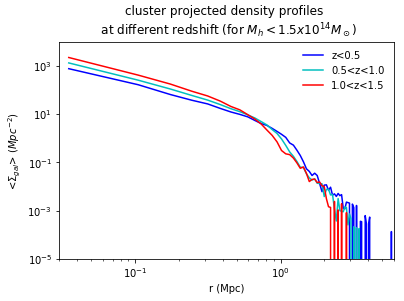

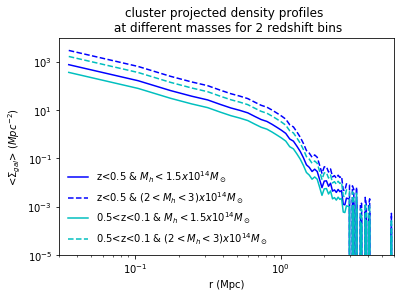

In [20]:
#plot the composite projected density profiles (the mean galaxy density per cluster in units of Mpc**2)

plt.figure()
plt.title('cluster projected density profiles \n at different redshift (for $M_{h}<1.5x10^{14}M_\odot$)')
plt.plot(dist_bin_center,hist_dist_bin0[0]/(Nclus_per_bin[0]*3.14*dist_bin_center**2),'b',label = 'z<0.5')
plt.plot(dist_bin_center,hist_dist_bin1[0]/(Nclus_per_bin[1]*3.14*dist_bin_center**2),'c',label = '0.5<z<1.0')
plt.plot(dist_bin_center,hist_dist_bin2[0]/(Nclus_per_bin[2]*3.14*dist_bin_center**2),'r',label = '1.0<z<1.5')
# to add errorbars (negeligeable)
#plt.errorbar(bin_center,hist_dist_bin0[0]/(Nclus_per_bin[0]*3.14*dist_bin_center**2),yerr=np.sqrt(hist_dist_bin0[0])/(Nclus_per_bin[0]*3.14*dist_bin_center**2)) 
plt.yscale('log')
plt.xscale('log')
plt.ylabel('<$\Sigma_{gal}$> ($Mpc^{-2}$)');
plt.xlabel('r (Mpc)');
plt.ylim(0.00001,1e4)
plt.xlim(0.03,6)
plt.legend(frameon =False)

plt.figure()
plt.title('cluster projected density profiles \n at different masses for 2 redshift bins')
plt.plot(dist_bin_center,hist_dist_bin0[0]/(Nclus_per_bin[0]*3.14*dist_bin_center**2),'b',label = 'z<0.5 & $M_{h}<1.5x10^{14}M_\odot$')
plt.plot(dist_bin_center,hist_dist_bin0[0]/(Nclus_per_bin[3]*3.14*dist_bin_center**2),'b--',label = 'z<0.5 & $(2<M_{h}<3)x10^{14}M_\odot$')
plt.plot(dist_bin_center,hist_dist_bin0[0]/(Nclus_per_bin[1]*3.14*dist_bin_center**2),'c',label = '0.5<z<0.1 & $M_{h}<1.5x10^{14}M_\odot$')
plt.plot(dist_bin_center,hist_dist_bin0[0]/(Nclus_per_bin[4]*3.14*dist_bin_center**2),'c--',label = '0.5<z<0.1 & $(2<M_{h}<3)x10^{14}M_\odot$')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('<$\Sigma_{gal}$> ($Mpc^{-2}$)');
plt.xlabel('r (Mpc)');
plt.ylim(0.00001,1e4)
plt.xlim(0.03,6)
plt.legend(loc='lower left',frameon =False)

### At first sight does not look like NFW (or maybe truncated...), but more investigation is needed
### Signal up to r~2-3Mpc
### Concentration seems to increase with redshift at fixed mass and amplitude seems to increase with mass at fixed redshift

# 6 - Galaxy luminosity functions in clusters 

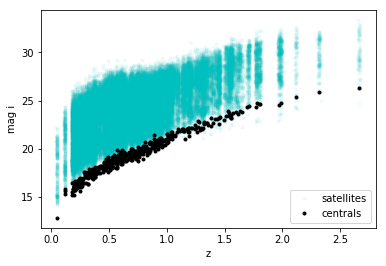

In [21]:
#Magnitude as a function of redshift for central and satellite galaxies

plt.figure()
plt.plot(cluster_data['redshift'],cluster_data['mag_i_lsst'],'c.',alpha=0.05,label='satellites')
plt.plot(cluster_data['redshift'][is_central],cluster_data['mag_i_lsst'][is_central],'k.',label='centrals')

plt.legend(loc=4)
plt.xlabel('z')
plt.ylabel('mag i');


### *Why is there no faint galaxies in haloes at low redshift? The same is true for galaxies outside of haloes. See https://github.com/LSSTDESC/DC2-analysis/issues/48*

In [22]:
#define the mass/redshift conditions of halos in each bin

zM_bin_LF = [(cluster_data['redshift']>0.25)*(cluster_data['redshift']<0.35)*(cluster_data['halo_mass']<1.5e14),\
        (cluster_data['redshift']>0.55)*(cluster_data['redshift']<0.65)*(cluster_data['halo_mass']<1.5e14),\
        (cluster_data['redshift']>0.90)*(cluster_data['redshift']<1.1)*(cluster_data['halo_mass']<1.5e14),\
        (cluster_data['redshift']>1.30)*(cluster_data['redshift']<1.6)*(cluster_data['halo_mass']<1.5e14)]

halo_list_LF = [cluster_data['halo_id'][is_central*zM_bin_LF[0]],cluster_data['halo_id'][is_central*zM_bin_LF[1]],cluster_data['halo_id'][is_central*zM_bin_LF[2]],cluster_data['halo_id'][is_central*zM_bin_LF[3]]]    
Nclus_per_bin_LF = [len(halo_list_LF[0]),len(halo_list_LF[1]),len(halo_list_LF[2]),len(halo_list_LF[3])]

print ("Number of clusters in each bin", Nclus_per_bin_LF)

Number of clusters in each bin [20, 41, 34, 19]


In [23]:
#compute the composite projected luminosity function of stallites in each bin, in apparent magnitude

hist_mag_app_bin0 = np.histogram(cluster_data['mag_i_lsst'][zM_bin_LF[0]*(~is_central)],bins=30,range=[15,30])
hist_mag_app_bin1 = np.histogram(cluster_data['mag_i_lsst'][zM_bin_LF[1]*(~is_central)],bins=30,range=[15,30])
hist_mag_app_bin2 = np.histogram(cluster_data['mag_i_lsst'][zM_bin_LF[2]*(~is_central)],bins=30,range=[15,30])
hist_mag_app_bin3 = np.histogram(cluster_data['mag_i_lsst'][zM_bin_LF[3]*(~is_central)],bins=30,range=[15,30])

LF_mapp_bin_center = 0.5*(hist_mag_app_bin0[1][1]-hist_mag_app_bin0[1][0])+hist_mag_app_bin0[1][0:-1]
LF_mapp_bin_size = LF_mapp_bin_center[1]-LF_mapp_bin_center[0]

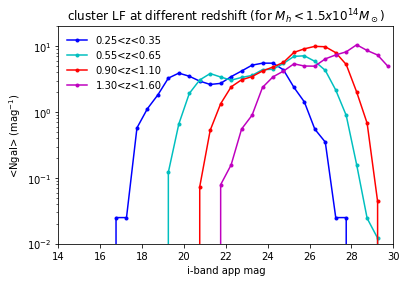

In [25]:
plt.figure()
plt.title('cluster LF at different redshift (for $M_{h}<1.5x10^{14}M_\odot$)')

plt.plot(LF_mapp_bin_center,LF_mapp_bin_size*hist_mag_app_bin0[0]/(Nclus_per_bin_LF[0]),'b.-',label = '0.25<z<0.35')
plt.plot(LF_mapp_bin_center,LF_mapp_bin_size*hist_mag_app_bin1[0]/(Nclus_per_bin_LF[1]),'c.-',label = '0.55<z<0.65')
plt.plot(LF_mapp_bin_center,LF_mapp_bin_size*hist_mag_app_bin2[0]/(Nclus_per_bin_LF[2]),'r.-',label = '0.90<z<1.10')
plt.plot(LF_mapp_bin_center,LF_mapp_bin_size*hist_mag_app_bin3[0]/(Nclus_per_bin_LF[3]),'m.-',label = '1.30<z<1.60')

plt.yscale('log')
plt.ylabel('<Ngal> (mag$^{-1}$)');
plt.xlabel('i-band app mag');
plt.legend(frameon =False)
plt.ylim(0.01,20)
plt.xlim(14,30);

### *Sharp unphysical decline in the LF at mag fainter than i = ~24 * 
### *At very first sight, LF seem OK for galaxies brighter than i ~ 24 (with a shape similar to a double Schechter function), but need more investigation* 

In [26]:
#compute the composite projected luminosity function of satellites in each bin, in absolute magnitude

hist_mag_abs_bin0 = np.histogram(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[0]*(~is_central)],bins=30,range=[-24.5,-13.5])
hist_mag_abs_bin1 = np.histogram(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[1]*(~is_central)],bins=30,range=[-24.5,-13.5])
hist_mag_abs_bin2 = np.histogram(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[2]*(~is_central)],bins=30,range=[-24.5,-13.5])
hist_mag_abs_bin3 = np.histogram(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[3]*(~is_central)],bins=30,range=[-24.5,-13.5])

LF_mabs_bin_center = 0.5*(hist_mag_abs_bin0[1][1]-hist_mag_abs_bin0[1][0])+hist_mag_abs_bin0[1][0:-1]
LF_mabs_bin_size = LF_mabs_bin_center[1]-LF_mabs_bin_center[0]

(0.01, 20)

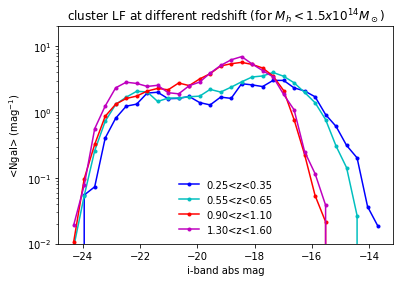

In [27]:
plt.figure()
plt.title('cluster LF at different redshift (for $M_{h}<1.5x10^{14}M_\odot$)')

plt.plot(LF_mabs_bin_center,LF_mabs_bin_size*hist_mag_abs_bin0[0]/(Nclus_per_bin_LF[0]),'b.-',label = '0.25<z<0.35')
plt.plot(LF_mabs_bin_center,LF_mabs_bin_size*hist_mag_abs_bin1[0]/(Nclus_per_bin_LF[1]),'c.-',label = '0.55<z<0.65')
plt.plot(LF_mabs_bin_center,LF_mabs_bin_size*hist_mag_abs_bin2[0]/(Nclus_per_bin_LF[2]),'r.-',label = '0.90<z<1.10')
plt.plot(LF_mabs_bin_center,LF_mabs_bin_size*hist_mag_abs_bin3[0]/(Nclus_per_bin_LF[3]),'m.-',label = '1.30<z<1.60')

plt.yscale('log')
plt.ylabel('<Ngal> (mag$^{-1}$)');
plt.xlabel('i-band abs mag');
plt.legend(frameon =False)
plt.ylim(0.01,20)

### *Sharp unexpected decline in the LF at mag fainter than i = ~-18 * 
### *At very first sight, LF seem OK for galaxies brighter than i ~ -20 (with a shape similar to a double Schechter function), but need more investigation* 

In [28]:
#test if the galaxy luminosity distribution of central galaxies is gaussian, as expected (test the null hypothesis that the distribution is normal)

print ('test in apparent mag')
print (normaltest(cluster_data['mag_i_lsst'][zM_bin_LF[0]*(is_central)]))
print (normaltest(cluster_data['mag_i_lsst'][zM_bin_LF[1]*(is_central)]))
print (normaltest(cluster_data['mag_i_lsst'][zM_bin_LF[2]*(is_central)]))
print (normaltest(cluster_data['mag_i_lsst'][zM_bin_LF[3]*(is_central)]))


print ('test in absolute mag')
print (normaltest(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[0]*(is_central)]))
print (normaltest(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[1]*(is_central)]))
print (normaltest(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[2]*(is_central)]))
print (normaltest(cluster_data['Mag_true_i_lsst_z0'][zM_bin_LF[3]*(is_central)]))


test in apparent mag
NormaltestResult(statistic=0.82295220486399479, pvalue=0.66267135703907898)
NormaltestResult(statistic=0.14779260072940897, pvalue=0.92876800175070906)
NormaltestResult(statistic=1.5707946297529876, pvalue=0.45593851463921586)
NormaltestResult(statistic=1.8303049392815973, pvalue=0.40045556411987154)
test in absolute mag
NormaltestResult(statistic=0.3826708242513322, pvalue=0.82585553972901748)
NormaltestResult(statistic=0.7410847713358143, pvalue=0.69035978781859608)
NormaltestResult(statistic=2.0516301733454281, pvalue=0.35850413434254386)
NormaltestResult(statistic=0.40853609783418393, pvalue=0.81524381667472556)


/pbs/throng/lsst/software/desc/python/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


### *Central galaxy luminosity distribution are compatible with being gaussians (as expected)*

# 7 - Color-magnitude diagrams in clusters

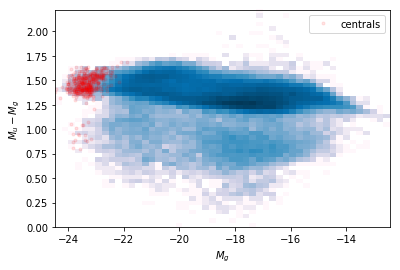

In [29]:
#plot the rest frame color magnitude diagram for all galaxies in clusters
#the density of satellites galaxies is shown in blue and the centrals are shownbythe red dots

plt.hist2d(cluster_data['Mag_true_g_lsst_z0'],cluster_data['Mag_true_u_lsst_z0']-cluster_data['Mag_true_g_lsst_z0'], bins=50, cmap='PuBu',norm=clr.LogNorm(),label = 'satellites');
plt.plot(cluster_data['Mag_true_g_lsst_z0'][is_central],cluster_data['Mag_true_u_lsst_z0'][is_central]-cluster_data['Mag_true_g_lsst_z0'][is_central],'r.',alpha=0.1,label = 'centrals')

plt.xlabel('$M_{g}$')
plt.ylabel('$M_{u}-M_{g}$');
plt.legend()

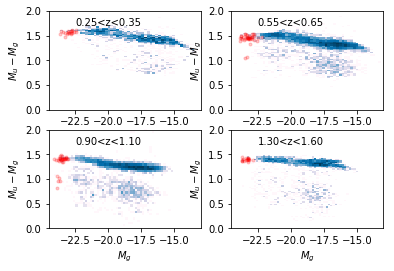

In [30]:
#plot the rest frame color magnitude diagram of memeber galaxies for clusters in different redshift bins
#the density of satellites galaxies is shown in blue and the centrals are shownbythe red dots

label = ['0.25<z<0.35','0.55<z<0.65','0.90<z<1.10','1.30<z<1.60']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(cluster_data['Mag_true_g_lsst_z0'][zM_bin_LF[i]],cluster_data['Mag_true_u_lsst_z0'][zM_bin_LF[i]]-cluster_data['Mag_true_g_lsst_z0'][zM_bin_LF[i]], bins=50, cmap='PuBu',norm=clr.LogNorm());
    plt.plot(cluster_data['Mag_true_g_lsst_z0'][zM_bin_LF[i]*is_central],cluster_data['Mag_true_u_lsst_z0'][zM_bin_LF[i]*is_central]-cluster_data['Mag_true_g_lsst_z0'][zM_bin_LF[i]*is_central],'r.',alpha=0.2)
    plt.xlim(-24.5,-13)
    plt.ylim(0,2)
    plt.xlabel('$M_{g}$')
    plt.ylabel('$M_{u}-M_{g}$');
    plt.text(-22.5,1.7,label[i])
    

### *Looks a bit weird, not enough blue cloud galaxies/too much red sequence galaxies, especially at high redshift, need more investigation*
### *Note some blue centrals, might causes centring issues*